# Spotify Playlist Prediction
**Kevin Yoon, Madeleine Nakada, Michelle Xie**

In [1]:
import pandas as pd
import json
import random
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import requests
import pprint
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

In [2]:
pp = pprint.PrettyPrinter(indent=4)

In [3]:
#from spotify import get_features

In [4]:
base_url = "https://api.spotify.com/v1"
token = "BQAOXWs6Miegor-NiOf9FTb-fQIV6IKhOuNI2LDrrtvh3oWsbqaYVQIVoXWu9HAxMzfGgawxWU2_uN3zu9w"
headers = {'Authorization': 'Bearer ' + token}


def get_features(songs):
    url = base_url + '/audio-features'
    payload = {'ids': ','.join(songs)}
    r =requests.get(url, headers=headers, params=payload)
    data = r.json()
    return data["audio_features"]

In [5]:
def progress_bar(index, total, failures):
    clear_output(wait=True)
    percent = index/total
    bars = "#" * int(percent * 30)
    lines = "-" * int((1-percent) * 30)
    display("|" + bars + lines + "| (%d/%d) with %d failures"%(index,total, failures))

In [6]:
# add some code here to randomize selection

In [7]:
path = './mpd.slice.0-999.json'

with open(path) as infile:
    data = json.load(infile)
playlists = pd.DataFrame(data['playlists'])
playlists.set_index("pid")
playlists.shape
# print(data.keys())
# print(len(data['playlists']))
# print(data['playlists'][0])
# pd.DataFrame.from_dict(data)
# print(data)
# data = json.loads('./data/mpd.slice.0-999.json')

(1000, 12)

In [8]:
feature_names = ["acousticness", "danceability","duration_ms",
            "energy","instrumentalness","key","liveness",
            "loudness","mode","speechiness","time_signature",
            "tempo","valence"]
for feature in feature_names:
    playlists[feature] = None

In [9]:
playlists.head()

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,time_signature,tempo,valence
0,false,NaN,None,1493424000,Throwbacks,47,37,6,1,52,...,None,None,None,None,None,None,None,None,None,None
1,false,NaN,None,1506556800,Awesome Playlist,23,21,5,1,39,...,None,None,None,None,None,None,None,None,None,None
2,false,NaN,None,1505692800,korean,51,31,18,1,64,...,None,None,None,None,None,None,None,None,None,None
3,false,NaN,None,1501027200,mat,107,86,4,1,126,...,None,None,None,None,None,None,None,None,None,None
4,false,NaN,None,1401667200,90s,16,16,7,2,17,...,None,None,None,None,None,None,None,None,None,None


In [10]:
failures = 0
for index, row in playlists.iterrows():
    progress_bar(index,playlists.shape[0], failures)
    features = {
        "acousticness": 0,
        "danceability": 0,
        "duration_ms" : 0,
        "energy" : 0,
        "instrumentalness" : 0,
        "key" : 0,
        "liveness" : 0,
        "loudness" : 0,
        "mode" : 0,
        "speechiness" : 0,
        "time_signature" : 0,
        "tempo" : 0,
        "valence" : 0,
    }
    artists = Counter()
    genres = Counter()
    all_features = set(features.keys())
    tracks = row["tracks"]
    songs = []
    counters = set(["artists", "genres"])
    for track in tracks:                
        track_id = track['track_uri'].split(":")[-1]
        songs.append(track_id)
        artists[track['artist_uri']] += 1
    try:
        song_data = get_features(songs)
        for song in song_data:
            for feature in all_features:
                if feature in counters:
                    features[song[feature]] += 1
                else:
                    features[feature] += song[feature]
        for feature in all_features:
            if feature in counters:
                continue
            else:
                features[feature] = features[feature] / float(row["num_tracks"])
                if feature == "time_signature":
                    features[feature] = int(features[feature] + 0.5)
                playlists.at[index, feature] = features[feature]
    except:
        failures += 1
    
#     print(features)

'|#############################| (999/1000) with 227 failures'

In [11]:
playlists.head()

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,time_signature,tempo,valence
0,false,NaN,221777,1493424000,Throwbacks,47,37,6,1,52,...,0.782173,0.00067601,5.03846,0.192127,-4.88194,0.692308,0.107021,4,123.007,0.642904
1,false,NaN,298844,1506556800,Awesome Playlist,23,21,5,1,39,...,0.691077,0.22227,4.46154,0.178433,-8.29167,0.538462,0.0884487,4,122.67,0.476667
2,false,NaN,219375,1505692800,korean,51,31,18,1,64,...,0.693203,0.000637814,5,0.169028,-4.87416,0.515625,0.0962875,4,114.601,0.565078
3,false,NaN,None,1501027200,mat,107,86,4,1,126,...,None,None,None,None,None,None,None,None,None,None
4,false,NaN,255014,1401667200,90s,16,16,7,2,17,...,0.650535,0.0818755,3.35294,0.166524,-7.63447,0.823529,0.0411588,4,127.76,0.490765


## Clean Up Data
Remove entries for which we couldn't get all song data

In [12]:
clean_data = playlists[playlists["time_signature"] > 0]
print(clean_data.shape)
clean_data

(773, 24)


,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,...,energy,instrumentalness,key,liveness,loudness,mode,speechiness,time_signature,tempo,valence
0,false,NaN,221777,1493424000,Throwbacks,47,37,6,1,52,...,0.782173,0.00067601,5.03846,0.192127,-4.88194,0.692308,0.107021,4,123.007,0.642904
1,false,NaN,298844,1506556800,Awesome Playlist,23,21,5,1,39,...,0.691077,0.22227,4.46154,0.178433,-8.29167,0.538462,0.0884487,4,122.67,0.476667
2,false,NaN,219375,1505692800,korean,51,31,18,1,64,...,0.693203,0.000637814,5,0.169028,-4.87416,0.515625,0.0962875,4,114.601,0.565078
4,false,NaN,255014,1401667200,90s,16,16,7,2,17,...,0.650535,0.0818755,3.35294,0.166524,-7.63447,0.823529,0.0411588,4,127.76,0.490765
5,false,NaN,239453,1430956800,Wedding,71,56,3,1,80,...,0.717812,0.000629673,4.5875,0.212533,-5.8844,0.7375,0.0766775,4,122.845,0.56855
6,false,NaN,213036,1477094400,I Put A Spell On You,15,13,2,1,16,...,0.7795,0.038226,4.3125,0.223025,-6.62162,0.8125,0.0467938,4,123.208,0.505937
7,false,NaN,239148,1509321600,2017,52,48,38,1,53,...,0.575792,0.0763899,4.83019,0.123749,-7.81692,0.339623,0.0756094,4,121.133,0.44676
8,false,NaN,216281,1508976000,BOP,37,23,21,2,46,...,0.686239,0.0571821,5.52174,0.188674,-6.39372,0.717391,0.0503109,4,130.533,0.538587
9,false,NaN,204642,1501804800,old country,20,18,10,1,21,...,0.631476,0.0056093,5.66667,0.166543,-8.44071,0.761905,0.0495381,4,122.324,0.623381
10,false,NaN,227825,1509321600,abby,60,40,36,2,72,...,0.632319,8.54843e-05,5.41667,0.179407,-6.19782,0.611111,0.187282,4,126.789,0.461528


## Explore The Data

First we want to see if there are any features in which we don't see much variation, since these will likely not be helpful for prediction

In [19]:
big = 30

fig, ax=plt.subplots(13, 13, figsize=(130,130))
graphs = ax.ravel()
i = 0
for feature1 in feature_names:
    for feature2 in feature_names:
        graph = graphs[i]
        graph.scatter(clean_data[feature1], clean_data[feature2])
        graph.set_title(feature1 + " vs " + feature2, fontsize=big)
#     print(feature)
#     graph.hist(clean_data[feature], 25, histtype='stepfilled')
#     graph.set_title(feature)
#     graph.legend()
        i += 1

*Observations Here*

([array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]),
  array([0., 0., 0., 1., 0., 0.

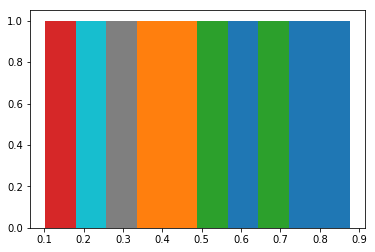

In [20]:
data = clean_data["valence"]
plt.hist(data, histtype="stepfilled")

## Split train and test data

In [ ]:
train_data, test_data = train_test_split(clean_data, test_size=0.2, random_state=42)

In [40]:
train_data.shape, test_data.shape

((618, 24), (155, 24))

In [9]:
train_data.head()

,collaborative,description,duration_ms,modified_at,name,num_albums,num_artists,num_edits,num_followers,num_tracks,pid,tracks
29,false,NaN,8059613,1506384000,groovy,39,39,16,1,40,29,"[{'pos': 0, 'artist_name': 'Lauv', 'track_uri'..."
535,false,NaN,12714068,1359244800,halcyon,11,3,5,4,46,535,"[{'pos': 0, 'artist_name': 'Ellie Goulding', '..."
695,false,NaN,4444821,1415577600,three,17,19,4,1,20,695,"[{'pos': 0, 'artist_name': 'Chorus - Hercules'..."
557,false,NaN,16177296,1508803200,Work,68,59,14,1,70,557,"[{'pos': 0, 'artist_name': 'Lil Wyte', 'track_..."
836,false,NaN,3999213,1506470400,boujee,17,16,2,1,19,836,"[{'pos': 0, 'artist_name': 'A$AP Ferg', 'track..."


world
